In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-03-12 00:38:10.129526: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 00:38:11.562021: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 00:38:15.054712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 00:38:19.424697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load all the data/images into tensorflow
"""
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)
"""
IMAGE_SIZE = 256
BATCH_SIZE = 32 # Usually it's a standard, so 32
CHANNELS = 3 # 3 RGB Channels
EPOCHS = 50 # It can be any value, but 50 is appropriate
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    # All images are 256x256 pixels
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
len(dataset) # 68 as we have total 68 batches with each batch of 32 images

68

2024-03-12 01:05:15.284664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


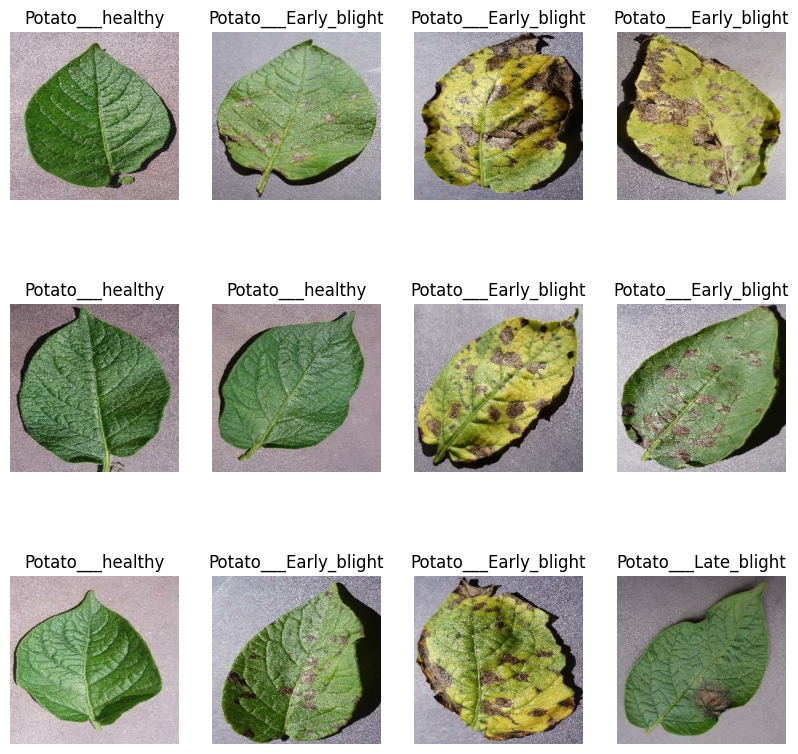

In [16]:
# Increase area for each image being printed to 10x10
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    # Display first 12 images of the first batch of 32 images
    for i in range(12):
        # Make a subplot, like a matrix of images
        ax = plt.subplot(3,4,i+1)
        
        # Everytime we see different image as shuffle=True, so 1st image keeps getting changed
        plt.imshow(image_batch[i].numpy().astype("uint8")) # It is float, so convert to int
    
        # label_batch[0] returns index 0, 1 or 2
        # so we do, class_names[label_batch[0]]
        # class_names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
        plt.title(class_names[label_batch[i]]) # Which type of image is this, is it early blight, late blight or healthy
    
        # Remove the axis
        plt.axis("off") 


    
    """
    print(image_batch[0].numpy()) # Convert Tensor to numpy array, it gives a 3d array of the first image at 0th position where each value is between 0 to 255
    print(image_batch[0].shape) # (256, 256, 3)
    
    print(image_batch.shape) # (32, 256, 256, 3) : 32 images, each image is 256,256, 3 is RGB channels
    print(label_batch.numpy()) # Convert tensor to numpy array:
    # [1 1 2 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1] : 3 classes so, 0 for early blight, 1 for late blight, 2 for healthy
    """

In [ ]:
# Spliiting DataSet

"""
80% ==> training
20% ==> 10% validation, 10% testing
We run 50 EPOCHS
1 epoch means: train the model on the 80% data and then at the end of 1 epoch, validate it using 10% validation data
and do this 50 times
once this cycle is completed
test the model using the 10% testing data
"""

In [17]:
# Length of Dataset = 68 batches, where each batch has 32 images
train_size = 0.8 # 80%
len(dataset)*train_size # 80% of 68

54.400000000000006

In [18]:
# Take first 54 batches of data out of 68 and call it train_ds(train data set)
train_ds = dataset.take(54)
len(train_ds)

54

In [19]:
# Now skip the first 54 batches out of 68 and get the rest of the data (the remaining 20%)
test_ds = dataset.skip(54) # Similar to slicing in python [54:]
len(test_ds)

14

In [21]:
# Now again split this 20% into 2 parts: 10% validation, 10% testing
val_size = 0.1
len(dataset)*val_size # 10% of my entire data set(68 batches) is 6

6.800000000000001

In [22]:
# Validation Dataset
val_ds = test_ds.take(6) # Take first 6 batches out of the remaining 20% the batches, which is 10% of it
len(val_ds)


6

In [23]:
# Now skip the first 6 batches of the 20% dataset, which gives our 10% test dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

In [24]:
# Function to do all the above data splitting calculations automatically
# Parameters:
"""
ds: dataset
train_split: ratio of training data
val_split: ratio of validation data
test_split: ration of testing data
"""
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    # Size of dataset
    ds_size = len(ds)

    # If shuffle is True then shuffle the dataset
    if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12) # seed is for predictiblity, so if you have same seed everytime, it give you same result everytime, it can be any number (5, 7, ect...)

    # Training Data Size
    # 80% of dataset(ds) and convert to int, so that we don't get float values
    train_size = int(train_split * ds_size)

    # Validation Data Size
    val_size = int(val_split * ds_size)

    # Training Data Set
    # Take the first (train_size) batches out of all the batches of data, where each batch has 32 images
    train_ds = ds.take(train_size)

    # From the remaining 20% of data, take first 10% or (val_size) of data as validation data
    val_ds = ds.skip(train_size).take(val_size)

    # From the reamining 20% data, skip the first 10% or (val_size) of data and use the remaining data as testing data
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [25]:
# Calling function on the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [31]:
# Caching of the training data set
# train_ds.cache(): It will read the image from the memory in the 1st iteration, and when you need the same image, it will keep that image in the memory, so that in every EPOCh we do not need to keep loading it again and again, which improves the performance of the pipeline
# shuffle: will shuffle the images
# prefetch: If we are using GPU and CPU then, if GPU is busy training the data then prefetch will load the next set of batch from the disk and that improves the performance.

# Explaination for : train_ds.cache().shuffle(1000).prefetch()
"""
 (Why use prefectch?)
 Refer Image: CPU_GPU_1
 When loading images, say 32 images at a time and say we have a GPU (eg, Titan RTX)
 When it(GPU) is training, we are not using CPU when GPU is training because CPU is sitting idle
 then when GPU is done, CPU again reads the batch and then GPU is added, so for example in image it takes total 12 seconds

 But when using prefetch and caching : Refer CPU_GPU_2
 While GPU is training batch 1, CPU will be loading next batch(batch 2), that's what prefetch does basically

 (Why use cache?)
 cache on the other hand, refer CACHING_1 image
 In that, in the first row the blue part represents the images being read
 So in the first EPOCH we read images, now again in the 2nd EPOCH same images are being read (Which can be seen in the 2nd blue part)

 But if we use cache(), refere CACHING_2 image
 In this image, we don't see the blue block again, we see it only once
 So by doing that we save time reading those images.
"""
# prefetch(buffer_size=tf.data.AUTOTUNE) : Let tensorflow determine how many batches to load while GPU is training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Similarly for validation and testing data set
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# So far datasets are optimized for training performance, so training will run fast.